# NLP Project - Predicting Programming Language

## Summary

Can the primary programming language of the repository be determine through Natural Language Processing analysis of the readme text?

For this project, we will be scraping data from GitHub repository README files. The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

* Who are our customers?
    - general audience
* What is the problem?
    - want to predict program language from words in readme content
* What solution do you propose?
    - Explore readme content for common words and phrases to identify features 
    - Model on Bag or Words and TF-IDF 
* How will you know if your work is good?
    - model accuracy will be better than baseline

### Work Plan

**Assignment**
- For this project, you will be scraping data from GitHub repository README files. The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

**Approach**
- Using webscraping collect readme text and programming language from a minimum of 100 GitHub repositories
- Explore the collected information to determine features for modeling
- Verify dataset is not imbalanced, correct with over/under sampling if needed
- Create a Baseline Model using most frequent language in dataset as prediction
- Use BOW (Bag of Words) and TF-IDF machine learning algorithms to improve prediction accuracy/F1 score/precision/recall
- Identify conclusions and next steps


## Imports


In [1]:
import acquire_ry
import ry_prepare
import ry_wrangle
import explore
import model as m
import pandas as pd
explore.set_plotting_defaults()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Acquire the Data

- Decided to search for repos with the word "environmental" to see if there was a language that was in more frequent use for these repos
- Created function to fetch all urls from the first search page and return them as a list
    - Discovered each search page contained links to 10 repos
- With that list of urls then inspected the repo for the HTML needed to get the readme text and primary(first listed) programming language
- Updated url function to iterate through search pages and return flattened list of urls
    - had to only fetch info from repos with needed text (exclude empty or repos with text not in container)
    - this returned 827 observations for 100 search pages (or 1,000 repos) scrapped
- cached .json file for further use as function run time is very high
- all functions stored in acquire.py file for future replication


# Prepare the Data

- load data from cached file
- noted that over 10 different languages are present in the dataset
    - decided to focus on the top 4 in our dataset = Python, JavaScript, HTML, Java
    - added words column and doc_length column in preparation for Explore
- cleaned data
    - change all to lowercase, remove special characters by converting to ascii then returning to UTF-8, and replace anything that is not a letter, number, whitespace or a single quote
    - Use NLTK TlktokTokenizer to separate/tokenize text
    - Remove stopwords from text with function that allows for additional words to exclude, or words to not exclude
        - NOTE: during Exploration noticed words 'data', 'file', and 'environmental' appear in the top 5 words for all categories
        - Added these words to the stopwords list to reduce noise
     - Create column of stemmed text and separate column of lemmatized text for Exploration and Modeling
- Split the dataset into train, validate, and test datasets and defined X and y sets for modeling, also return a separate set train_exp for Exploration

In [2]:
# get datasets
train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = ry_wrangle.wrangle_github(cached=True)

acquiring data
preparing data
splitting data
complete
X-train shape (234, 6) X_validate shape (79, 6) X_test shape (79, 6)


# Explore the Data

- Check for imbalance in the dataset
    - Balance looks ok, do not need to over/under sample
- create list of words by language category
- noticed words 'data', 'file', and 'environmental' appear in the top 5 words for all categories
    - these words have been removed to reduce noise


In [3]:
# check balance of dataset for under/over sampling
explore.check_proportion(train_exp)
# balance is not bad, will not need to over/under sample

,n,percent
Python,83,0.354701
JavaScript,62,0.264957
HTML,49,0.209402
Java,40,0.170940


In [4]:
# create a list of words for each language category and remove single letter words
python_words, js_words, html_words, java_words = explore.create_lang_word_list(train_exp)
# get the count of words by category
python_freq, js_freq, html_freq, java_freq = explore.get_count_word_freq(python_words, js_words, html_words, java_words)

In [5]:
python_freq
# note: 4 most common = '00', 'file', 'data', 'environmental'
# results after reduced noise

00                                                               226
using                                                            121
install                                                          104
sensor                                                           100
database                                                          97
                                                                ... 
hirsenkornvandriestengarciaramosschiementz                         1
reaktionen                                                         1
7440                                                               1
mitchellwork                                                       1
applicationjsonxposthttp1270015150v1entitiesent1environments'      1
Length: 6976, dtype: int64

In [6]:
js_freq
# note: 'data', 'file', 'environmental' are in top 5 words
# results after reduced noise

system             81
project            77
sensor             75
device             75
install            74
                   ..
number6             1
delhi               1
integrity           1
uppercase           1
noninfringement     1
Length: 4331, dtype: int64

In [7]:
html_freq
# note: 'data', 'file', 'environmental' are top 3 words
# results after reduced noise

worcester          47
nd                 46
retrieved          42
description        41
source             41
                   ..
neither2            1
gofundme            1
500                 1
everysecond         1
noninfringement     1
Length: 2495, dtype: int64

In [8]:
java_freq
# note: 'data', 'file', 'environmental' are in top 5 words
# results after reduced noise

property                    103
&#9;                         85
new                          42
environment                  37
configuration                32
                           ... 
returnheadersfinal            1
clean                         1
copyright2010                 1
headquarterheadquarterui      1
mailer                        1
Length: 1806, dtype: int64

In [9]:
# combine list of word counts into df for further exploration
word_counts = explore.create_df_word_counts(python_freq, js_freq, html_freq, java_freq)
word_counts.head()

,Python,JavaScript,HTML,Java,all_words
&#9;,29,4,3,85,121
&#9;&#9;,0,0,0,1,1
&#9;download,1,0,0,0,1
00,226,0,0,0,226
000,1,0,0,0,1


Next, compute proportion of each string that for each language.    
Because the languages are relatively balanced, we should see about the same proportion as the distibution in the dataset. If we see significantly higher or lower proportion, then that word might be a good feature in predicting that language.    
A chi-square test could confirm or deny significance if needed.



In [10]:
word_counts = explore.word_counts_proportion(word_counts)
word_counts.head(10)

,Python,JavaScript,HTML,Java,all_words,prop_python,prop_js,prop_html,prop_java
&#9;,29,4,3,85,121,0.239669,0.033058,0.024793,0.702479
&#9;&#9;,0,0,0,1,1,0.000000,0.000000,0.000000,1.000000
&#9;download,1,0,0,0,1,1.000000,0.000000,0.000000,0.000000
00,226,0,0,0,226,1.000000,0.000000,0.000000,0.000000
000,1,0,0,0,1,1.000000,0.000000,0.000000,0.000000
000000,0,5,0,0,5,0.000000,1.000000,0.000000,0.000000
0000dd,0,1,0,0,1,0.000000,1.000000,0.000000,0.000000
0023,1,0,0,0,1,1.000000,0.000000,0.000000,0.000000
003,1,0,0,0,1,1.000000,0.000000,0.000000,0.000000
005,1,0,0,0,1,1.000000,0.000000,0.000000,0.000000


**Takeaways**

- `&#9;` highest frequency is Java, present in others but much lower, might work for feature? or remove for noise?
- all instances of '00' are Python
- all instances of '000000' are JavaScript

not sure that these are good takeaways or features yet


For now, though, we will filter out rows with strings that only occur less a certain amount, as they are likely not going to provide much information. Let's first look at the distribution of counts to decide where that cutoff will be.

In [11]:
print("The number of words that occur n times: ")
word_counts['all_words'].value_counts().head(20)

The number of words that occur n times: 


1     6423
2     1821
3      709
4      421
5      279
6      208
7      153
8      121
9      109
11      80
10      79
12      73
13      59
14      45
16      45
15      38
19      37
22      33
17      32
20      26
Name: all_words, dtype: int64

In [12]:
# filter out all words that occur less than 20 times
word_counts = word_counts[word_counts['all_words'] >= 20]
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, &#9; to zero
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Python       428 non-null    int64  
 1   JavaScript   428 non-null    int64  
 2   HTML         428 non-null    int64  
 3   Java         428 non-null    int64  
 4   all_words    428 non-null    int64  
 5   prop_python  428 non-null    float64
 6   prop_js      428 non-null    float64
 7   prop_html    428 non-null    float64
 8   prop_java    428 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 33.4+ KB


## Feature Selection Words
This leaves us with 428 words which seems like a good amount (better than 603 with only 15 as cutoff).

We can now use this data set to answer some interesting questions:

Are there words that should be added to the stopword list?
- added 'file', 'data', 'environmental' to the list
- only remaining shared word in Top 5 is 'sensor' and only shared by Python and JavaScript

Are there any words that are unique to one language that could be a feature?
- Yes, have the variables of these words but unsure how to use them as a feature


In [13]:
python_feature = word_counts[word_counts.prop_python == 1.0].sort_values(by='Python', ascending=False)
# These words occur exclusively in Python readme texts. They might be a good list for a Python feature?
python_feature_list = python_feature.index.to_list()

In [14]:
python_feature_list

['00',
 'de',
 'mycodo',
 'classification',
 'cnn',
 'barque',
 'grasp',
 'la',
 'convolutional',
 'outlier']

In [15]:
# repeat for other languages
js_feature = word_counts[word_counts.prop_js == 1.0].sort_values(by='JavaScript', ascending=False)
js_feature_list = js_feature.index.to_list()

In [16]:
js_feature_list

['gps', 'epaper', 'waved']

In [17]:
html_feature = word_counts[word_counts.prop_html == 1.0].sort_values(by='HTML', ascending=False)
html_feature_list = html_feature.index.to_list()

In [18]:
html_feature_list

['worcester']

In [19]:
java_feature = word_counts[word_counts.prop_java == 1.0].sort_values(by='Java', ascending=False)
java_feature_list = java_feature.index.to_list()

In [20]:
java_feature_list

['propertiesmergerbuilder',
 'bean',
 'environmentspecificpropertiesmergerbuilder',
 'mergerbuilder']

## Visualize

<Figure size 864x576 with 0 Axes>

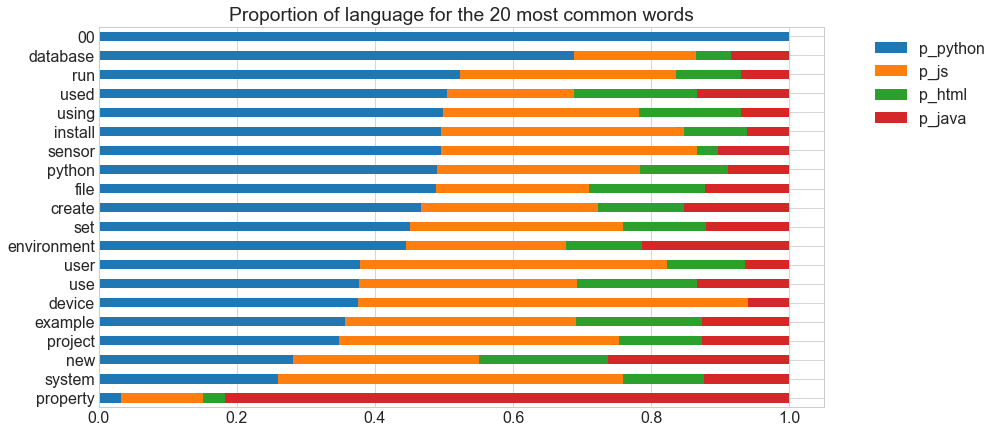

In [21]:
# visualize the % of the term in each language
explore.proportion_visualization(word_counts)

## Bigrams

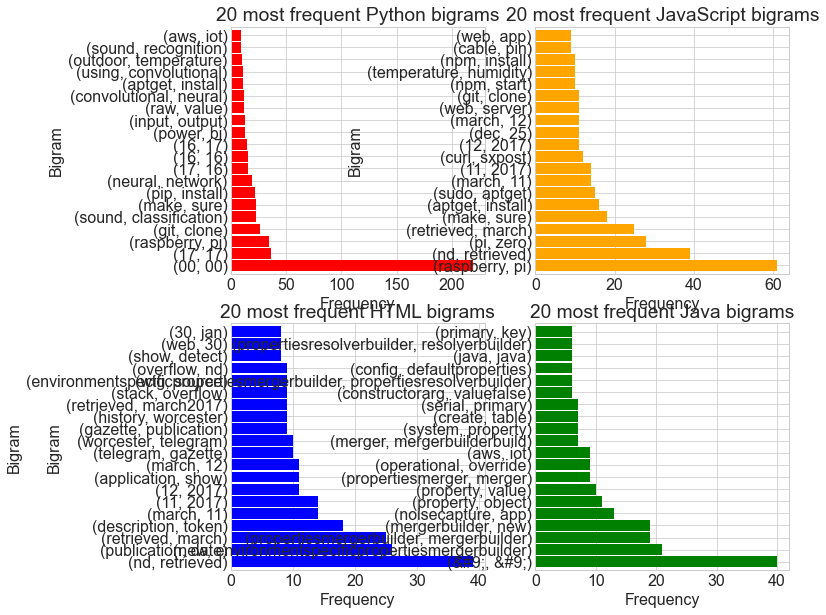

In [22]:
python_bigrams, js_bigrams, html_bigrams, java_bigrams = explore.create_bigrams(python_words, js_words, html_words, java_words)
explore.plot_bigrams(python_bigrams, js_bigrams, html_bigrams, java_bigrams)

## Statistical Testing

- Is the average word count significantly different from the population mean for each language?
- Using a one sample, 2 tail t-test determine if the mean word count (doc_length) for each language is significantly different from the population (overall mean)

Ho: There is no significant difference     
Ha: There is a significant difference     
alpha: .05

**Conclusions**
- For Python, JavaScript, and Java there is no significant difference in the readme length vs the overall mean length
- For HTML there is a significant difference

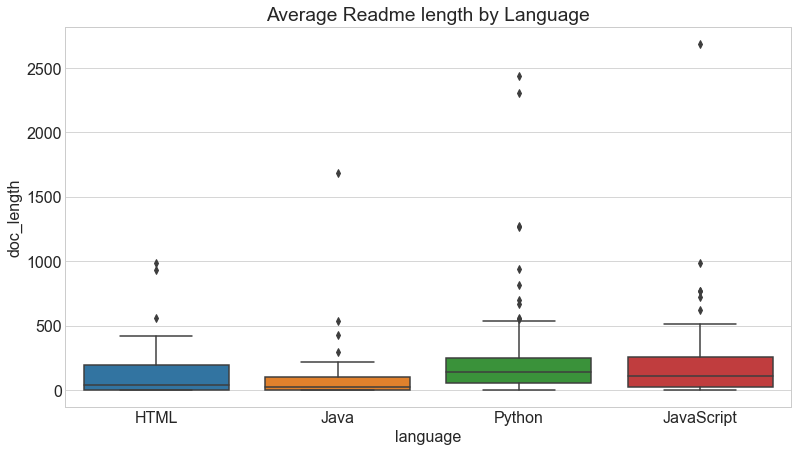

In [23]:
# Visualize programming language by readme length
explore.sns_boxplot(train_exp)

In [24]:
# create sample variables for stats test
python_sample = train_exp[train_exp.language=='Python'].doc_length
js_sample = train_exp[train_exp.language=='JavaScript'].doc_length
html_sample = train_exp[train_exp.language=='HTML'].doc_length
java_sample = train_exp[train_exp.language=='Java'].doc_length
overall_mean = train_exp.doc_length.mean()

In [25]:
# Python vs. overall mean
explore.ttest_1samp(python_sample, overall_mean)
# We fail to reject the null hypothesis and conclude there is no significant difference.

False


(1.3646833174208424, 0.1760858155624954)

In [26]:
# JavaScript vs. overall mean
explore.ttest_1samp(js_sample, overall_mean)
# We fail to reject the null hypothesis and conclude there is no significant difference.

False


(0.39910939021510883, 0.6912064458483929)

In [27]:
# HTML vs. overall mean
explore.ttest_1samp(html_sample, overall_mean)
# We reject the null hypothesis and conclude there is a significant difference for HTML readme files.

True


(-2.12158663408183, 0.03906197489424692)

In [28]:
# Java vs. overall mean
explore.ttest_1samp(java_sample, overall_mean)
# We fail to reject the null hypothesis and conclude there is no significant difference.

False


(-1.8057327766409508, 0.07868308420925468)

# Model the Data

### Feature Extraction
**Bag of Words**
Create CountVectorizer, which create bag-of-words model. We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document. https://scikit-learn.org/stable/modules/feature_extraction.html

**TF-IDF**
A word that has a high frequency in a document will have a high TF. If it appears in many other documents, than the information the word provides, or uniqueness of that word, is lowered. This is done mathematically by multiplying by the IDF, which will approach 0 and the number of documents with the word increases. Using TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features.

### Train Validation Test Split
- Data split already
- Data has been cleaned

**Open Question**
How would you use unique word lists as features for model instead of extracting features?

## Create Bag of Words for Modeling

In [29]:
# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(X_train.clean)

# Get dictionary. 
vectorizer.get_feature_names()

# Transform each sentences in vector space.
bow = vectorizer.transform(X_train.clean)
X_bow = bow

## Create TF-IDF for Modeling

In [30]:
tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(X_train.clean)
tfidf_sparse_matrix

# Transform to document-term matrix
vector_spaces = tfidf.transform(X_train.clean)
vector_spaces.toarray()

X_tfidf = tfidf_sparse_matrix

## Establish Baseline

In [31]:
# Getting baseline
baseline = len(train_exp[train_exp.language == 'Python']) / len(train_exp)
round(baseline,2)

0.35

## Build and Train Model

Will use both BOW and TF-IDF methods for the following models:
- Logistic Regression
- Decision Tree
- Random Forest
- K Nearest Neighbors

For Naive Bayes will use the TF-IDF vectorization only. But will try both Multinomial and Complement models. Naive Bayes is recommended for text classification, but the ComplementNB is recommended for imbalanced datasets.

In [32]:
# Logistic Regression
lm_bow, lm_tfidf = m.logistic_regression(X_train, y_train, X_bow = bow, X_tfidf = tfidf_sparse_matrix)

X_bow Accuracy: 82%

-----------------------
X_bow Confusion Matrix: 

 predicted   HTML  Java  JavaScript  Python
language                                  
HTML          29    14           5       1
Java           0    38           0       2
JavaScript     3     6          50       3
Python         2     5           2      74

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.85      0.59      0.70        49
        Java       0.60      0.95      0.74        40
  JavaScript       0.88      0.81      0.84        62
      Python       0.93      0.89      0.91        83

    accuracy                           0.82       234
   macro avg       0.81      0.81      0.80       234
weighted avg       0.84      0.82      0.82       234

-----------------------
TF-IDF Accuracy: 67%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language           

In [33]:
# Decision Tree
m.decesion_tree(X_train, y_train, X_bow, X_tfidf, k=5)

X_bow Accuracy: 56%

-----------------------
X_bow Confusion Matrix: 

 predicted   HTML  Java  JavaScript  Python
language                                  
HTML          16    30           3       0
Java           2    36           1       1
JavaScript     5    24          29       4
Python         7    22           4      50

-----------------------
X_bow Decesion Tree Classification Report:
               precision    recall  f1-score   support

        HTML       0.53      0.33      0.41        49
        Java       0.32      0.90      0.47        40
  JavaScript       0.78      0.47      0.59        62
      Python       0.91      0.60      0.72        83

    accuracy                           0.56       234
   macro avg       0.64      0.57      0.55       234
weighted avg       0.70      0.56      0.58       234

-----------------------
TF-IDF Accuracy: 58%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                 

In [34]:
# Random Forest
rf_bow, rf_tfidf = m.random_forest(X_train, y_train, X_bow, X_tfidf, k=6)

X_bow Accuracy: 79%

-----------------------
X_bow Confusion Matrix: 

 predicted   HTML  Java  JavaScript  Python
language                                  
HTML          42     0           4       3
Java          16    18           1       5
JavaScript     9     0          49       4
Python         6     0           2      75

-----------------------
X_bow Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.58      0.86      0.69        49
        Java       1.00      0.45      0.62        40
  JavaScript       0.88      0.79      0.83        62
      Python       0.86      0.90      0.88        83

    accuracy                           0.79       234
   macro avg       0.83      0.75      0.76       234
weighted avg       0.83      0.79      0.78       234

-----------------------
TF-IDF Accuracy: 82%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                 

In [35]:
# KNN
m.knn(X_train, y_train, X_bow, X_tfidf, k=5)

X_bow Accuracy: 44%

-----------------------
X_bow Confusion Matrix: 

 predicted   HTML  Java  JavaScript  Python
language                                  
HTML          31     6           9       3
Java          20    15           5       0
JavaScript    18    14          26       4
Python        15    22          15      31

-----------------------
X_bow KNN Classification Report:
               precision    recall  f1-score   support

        HTML       0.37      0.63      0.47        49
        Java       0.26      0.38      0.31        40
  JavaScript       0.47      0.42      0.44        62
      Python       0.82      0.37      0.51        83

    accuracy                           0.44       234
   macro avg       0.48      0.45      0.43       234
weighted avg       0.54      0.44      0.45       234

-----------------------
TF-IDF Accuracy: 30%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                           

In [36]:
# MultinomialNB
m.multinomial_naive_bayes(X_train, y_train, X_tfidf)

TF-IDF Accuracy: 57%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                                  
HTML          11     0           3      35
Java           2     5           4      29
JavaScript     1     0          35      26
Python         0     0           0      83

-----------------------
TF-IDF Multinomial Niave Bayes Classification Report:
               precision    recall  f1-score   support

        HTML       0.79      0.22      0.35        49
        Java       1.00      0.12      0.22        40
  JavaScript       0.83      0.56      0.67        62
      Python       0.48      1.00      0.65        83

    accuracy                           0.57       234
   macro avg       0.77      0.48      0.47       234
weighted avg       0.73      0.57      0.52       234



In [37]:
# ComplementNB 
cnb_tfidf = m.complement_naive_bayes(X_train, y_train, X_tfidf)

TF-IDF Accuracy: 68%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                                  
HTML          38     2           5       4
Java          17    19           1       3
JavaScript    10     1          42       9
Python        14     3           5      61

-----------------------
TF-IDF Complement Niave Bayes Classification Report:
               precision    recall  f1-score   support

        HTML       0.48      0.78      0.59        49
        Java       0.76      0.47      0.58        40
  JavaScript       0.79      0.68      0.73        62
      Python       0.79      0.73      0.76        83

    accuracy                           0.68       234
   macro avg       0.71      0.67      0.67       234
weighted avg       0.72      0.68      0.69       234



## Validate

The 3 top performing algorithms were moved on to the validate dataset to test on unseen data.
- Logistic Regression (BOW and TF-IDF)
- Random Forest (BOW and TF-IDF)
- Complement Naive Bayes (TF-IDF)


In [38]:
#vectorizer = CountVectorizer(stop_words='english', 
#                              min_df=20, 
#                              ngram_range=(1,2), 
#                              binary=True)

# Learn vocabulary in sentences. 
#vectorizer.fit(X_validate.clean)

# Get dictionary. 
#vectorizer.get_feature_names()

# Transform each sentences in vector space.
V_bow = vectorizer.transform(X_validate.clean)

In [39]:
#tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
#                              ngram_range=(1,2), 
#                              binary=True)

tfidf_sparse_matrix = tfidf.transform(X_validate.clean)
tfidf_sparse_matrix

V_tfidf = tfidf_sparse_matrix

In [40]:
# Logistic Regression
m.validate_logistic_regression(X_validate, y_validate, V_bow, V_tfidf, lm_bow, lm_tfidf)

X_bow Accuracy: 49%

-----------------------
X_bow Confusion Matrix: 

 predicted   HTML  JavaScript  Python
language                            
HTML           7           4       5
Java           7           3       4
JavaScript     2          10       9
Python         1           5      22

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.41      0.44      0.42        16
        Java       0.00      0.00      0.00        14
  JavaScript       0.45      0.48      0.47        21
      Python       0.55      0.79      0.65        28

    accuracy                           0.49        79
   macro avg       0.35      0.42      0.38        79
weighted avg       0.40      0.49      0.44        79

-----------------------
TF-IDF Accuracy: 51%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  JavaScript  Python
language                            
HTML           9        

In [41]:
# Random Forest
k=6
m.validate_random_forest(X_validate, y_validate, V_bow, V_tfidf, k, rf_bow, rf_tfidf)

X_bow Accuracy: 42%

-----------------------
X_bow Confusion Matrix: 

 predicted   HTML  Java  JavaScript  Python
language                                  
HTML           6     0           3       7
Java           7     1           2       4
JavaScript     3     0           4      14
Python         2     0           4      22

-----------------------
X_bow Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.33      0.38      0.35        16
        Java       1.00      0.07      0.13        14
  JavaScript       0.31      0.19      0.24        21
      Python       0.47      0.79      0.59        28

    accuracy                           0.42        79
   macro avg       0.53      0.36      0.33        79
weighted avg       0.49      0.42      0.37        79

-----------------------
TF-IDF Accuracy: 48%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                 

In [42]:
# ComplementNB
m.validate_complement_naive_bayes(X_validate, y_validate, V_tfidf, cnb_tfidf)

TF-IDF Accuracy: 46%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                                  
HTML           8     0           2       6
Java           8     2           4       0
JavaScript     5     2           9       5
Python         4     1           6      17

-----------------------
TF-IDF Complement Niave Bayes Classification Report:
               precision    recall  f1-score   support

        HTML       0.32      0.50      0.39        16
        Java       0.40      0.14      0.21        14
  JavaScript       0.43      0.43      0.43        21
      Python       0.61      0.61      0.61        28

    accuracy                           0.46        79
   macro avg       0.44      0.42      0.41        79
weighted avg       0.46      0.46      0.45        79



## Test

The Top performing model was moved on to the test dataset.
- Random Forest (TF-IDF)

In [43]:
T_bow = vectorizer.transform(X_test.clean)
# tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
#                              ngram_range=(1,2), 
#                              binary=True)

tfidf_sparse_matrix = tfidf.transform(X_test.clean)
tfidf_sparse_matrix
T_tfidf = tfidf_sparse_matrix

In [44]:
# Random Forest
k=6
m.test_random_forest(X_test, y_test, T_tfidf, k, rf_tfidf)

TF-IDF Accuracy: 41%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  JavaScript  Python
language                            
HTML           2           4      10
Java           3           5       6
JavaScript     2           6      13
Python         3           1      24

-----------------------
TF-IDF Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.20      0.12      0.15        16
        Java       0.00      0.00      0.00        14
  JavaScript       0.38      0.29      0.32        21
      Python       0.45      0.86      0.59        28

    accuracy                           0.41        79
   macro avg       0.26      0.32      0.27        79
weighted avg       0.30      0.41      0.33        79



In [45]:
# Logistic Regression Test
m.test_logistic_regression(X_test, y_test, T_bow, T_tfidf, lm_bow, lm_tfidf)

X_bow Accuracy: 42%

-----------------------
X_bow Confusion Matrix: 

 predicted   HTML  Java  JavaScript  Python
language                                  
HTML           2     1           4       9
Java           2     0           6       6
JavaScript     3     1           9       8
Python         3     0           3      22

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.20      0.12      0.15        16
        Java       0.00      0.00      0.00        14
  JavaScript       0.41      0.43      0.42        21
      Python       0.49      0.79      0.60        28

    accuracy                           0.42        79
   macro avg       0.27      0.33      0.29        79
weighted avg       0.32      0.42      0.36        79

-----------------------
TF-IDF Accuracy: 43%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language           

# Interpret the Model

**Best Performing Model**
Our best performing model uses a Logistic Regression algorithm and TF-IDF to vectroize the text.
This model increased the prediction accuracy from a baseline of 35% to an average of 47% on unseen data.

The initial models performed well on the train dataset, however, when used on unseen data the accuracy was significantly reduced. This indicates that the models are overfit. Increasing the size of the dataset may help improve future models.


# Next Steps: What Can We Do Now?

The current clean and prepare methods eliminate text symbols not in English as noise. Would recommend either obtaining new dataset of only English repos or otherwise adjusting for non-English text.     

We identified lists of specific words that were unique to each language, but were unable to incorporate those lists into features.

Additionally, increasing the size of the dataset may help improve future models.